In [1]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# data
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

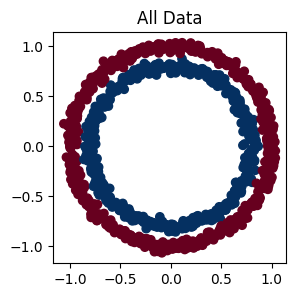

In [4]:
plt.figure(figsize=(3,3))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)
plt.title("All Data")
plt.show()

In [5]:
X_trainval, X_test, y_trainval, y_test =train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val =train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

(torch.Size([600, 2]),
 torch.Size([200, 2]),
 torch.Size([200, 2]),
 torch.Size([600]),
 torch.Size([200]),
 torch.Size([200]))

In [6]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [7]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid() # not needed with nn.BCEWithLogitsLoss() has sigmoid() build in

    def forward(self, x):
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [8]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

/home/dorota/projects/Deep-Machine-Learning-Dorota-Bjoorn/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_val, y_val = X_val.to(device), y_val.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
      val_logits = model_3(X_val).squeeze()
      val_pred = torch.round(torch.sigmoid(val_logits)) # logits -> prediction probabilities -> prediction labels
      val_loss = loss_fn(val_logits, y_val)
      val_acc = accuracy_fn(y_true=y_val,
                             y_pred=val_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Val Loss: {val_loss:.5f}, Val Accuracy: {val_acc:.2f}%")

Epoch: 0 | Loss: 0.69543, Accuracy: 49.67% | Val Loss: 0.69476, Val Accuracy: 50.50%
Epoch: 100 | Loss: 0.69023, Accuracy: 56.67% | Val Loss: 0.69044, Val Accuracy: 57.00%
Epoch: 200 | Loss: 0.68469, Accuracy: 71.83% | Val Loss: 0.68490, Val Accuracy: 71.00%
Epoch: 300 | Loss: 0.67692, Accuracy: 81.83% | Val Loss: 0.67835, Val Accuracy: 82.00%
Epoch: 400 | Loss: 0.66255, Accuracy: 87.83% | Val Loss: 0.66563, Val Accuracy: 83.50%
Epoch: 500 | Loss: 0.63720, Accuracy: 86.33% | Val Loss: 0.64413, Val Accuracy: 80.00%
Epoch: 600 | Loss: 0.59138, Accuracy: 89.83% | Val Loss: 0.60209, Val Accuracy: 84.50%
Epoch: 700 | Loss: 0.50969, Accuracy: 93.33% | Val Loss: 0.51965, Val Accuracy: 89.00%
Epoch: 800 | Loss: 0.37408, Accuracy: 98.67% | Val Loss: 0.38674, Val Accuracy: 97.00%
Epoch: 900 | Loss: 0.22590, Accuracy: 99.67% | Val Loss: 0.23875, Val Accuracy: 100.00%


In [32]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    test_logits = model_3(X_test).squeeze() # squeeze so y_preds same format as y_test
    test_pred = torch.round(torch.sigmoid(test_logits)) 
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

print(test_pred.shape, y_test.shape)
print(test_loss.item(), test_acc)

torch.Size([200]) torch.Size([200])
0.17769798636436462 98.5


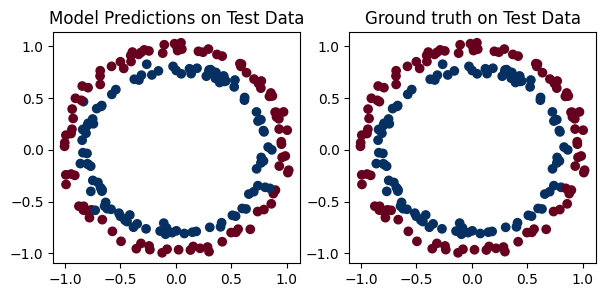

In [33]:
plt.figure(figsize=(7,3))

plt.subplot(1, 2, 1)
plt.scatter(X_test[:, 0], X_test[:, 1], c=test_pred, cmap=plt.cm.RdBu)
plt.title('Model Predictions on Test Data')

plt.subplot(1, 2, 2)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.RdBu)
plt.title('Ground truth on Test Data');